# Определение перспективного тарифа для телеком компании


## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание данных
### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
import seaborn as sns
from IPython.display import display
import numpy as np

In [2]:
#посмотрим первую таблицу со звонками
calls = pd.read_csv('/datasets/calls.csv')
display(calls)
calls.info()
calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [3]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [4]:
#заменим солбцы с датами и id на соответствующие типы
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
calls['id'] = calls['id'].astype('int')


In [5]:
calls.info() #Проверим замену

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null int64
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 6.2 MB


In [6]:
#посмотрим таблицу с интернет-сессиями
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
display(internet)
internet.info()
internet.describe()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


In [7]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [8]:
#аналогично проведем замену типов данных
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
internet['id'] = internet['id'].astype('int')

In [9]:
#посмотрим таблицу с информацией о сообщениях
messages = pd.read_csv('/datasets/messages.csv')
display(messages)
messages.info()
messages.describe()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [10]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [11]:
#аналогично проведем замену типов данных
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
messages['id'] = messages['id'].astype('int')

In [12]:
#посмотрим таблицу с информацией о трифах
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs)
tariffs.info()
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [13]:
#для удобства переименуем столбец с названием тарифа
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [14]:
tariffs.isna().sum()

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff                   0
dtype: int64

In [15]:
#посмотрим таблицу с информацией о пользователях
users = pd.read_csv('/datasets/users.csv')
display(users)
users.info()
users.describe()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [16]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [17]:
#аналогично проведем замену типов данных
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")

На первый взгляд кажется, что с данными всё в порядке. Пропуски по столбцу churn_date в таблице users объясняются тем, что если значение пропущено, то тариф ещё действовал на момент выгрузки данных

### Шаг 2. Подготовьте данные

Посчитайте для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножьте на значение из тарифного плана)

In [18]:
#Количество сделанных звонков
calls['month'] = calls['call_date'].dt.month_name()

In [19]:
#округлим значения так как это делает оператор
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [20]:
#нулевые звонки. Пока предположим, что это звонки, длительностью в одну минуту, так как у оператора в коде их программы не ceil, a floor. 
calls['duration'] = calls['duration'].replace(0, 1)

In [21]:
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,1,1000,July
1,10001,2018-08-17,1,1000,August
2,10002,2018-06-11,3,1000,June
3,10003,2018-09-21,14,1000,September
4,10004,2018-12-15,6,1000,December


In [22]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})\

In [23]:
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,August,418,52
1,1000,December,341,46
2,1000,July,346,47
3,1000,June,187,43
4,1000,May,164,22


In [24]:
#количество отправленных сообщений по месяцам
messages['month'] = messages['message_date'].dt.month_name()

In [25]:
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,June
1,10001,2018-10-08,1000,October
2,10002,2018-08-04,1000,August
3,10003,2018-06-16,1000,June
4,10004,2018-12-05,1000,December


In [26]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns = {'id':'messages_total_in_month'})\

In [27]:
user_messages.head()

,user_id,month,messages_total_in_month
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


In [28]:
#Объем израсходованного интернет-трафика по месяцам
internet['month'] = internet['session_date'].dt.month_name()

In [77]:
#округлим значения т.к. это делает Мегалайн
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('float64')

In [78]:
internet.head()

,id,mb_used,session_date,user_id,month
0,10000,113.0,2018-11-25,1000,November
1,10001,1053.0,2018-09-07,1000,September
2,10002,1198.0,2018-06-25,1000,June
3,10003,551.0,2018-08-22,1000,August
4,10004,303.0,2018-09-24,1000,September


In [31]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns = {'mb_used':'mb_used_in_month'})\

In [32]:
user_internet.head()

,user_id,month,mb_used_in_month
0,1000,August,14070
1,1000,December,9827
2,1000,July,14016
3,1000,June,23257
4,1000,May,2256


In [33]:
#помесячная выручка с каждого пользователя
#вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, 
#остаток умножьте на значение из тарифного плана
#соеденим все вышесозданные таблицу в один датафрейм
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month
0,1000,August,418.0,52.0,81.0
1,1000,December,341.0,46.0,70.0
2,1000,July,346.0,47.0,75.0
3,1000,June,187.0,43.0,60.0
4,1000,May,164.0,22.0,22.0


In [34]:
df = df.merge(user_internet, on=['user_id','month'], how='outer')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_used_in_month
0,1000,August,418.0,52.0,81.0,14070.0
1,1000,December,341.0,46.0,70.0,9827.0
2,1000,July,346.0,47.0,75.0,14016.0
3,1000,June,187.0,43.0,60.0,23257.0
4,1000,May,164.0,22.0,22.0,2256.0


In [35]:
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_used_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,August,418.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,December,341.0,46.0,70.0,9827.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,July,346.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,June,187.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,May,164.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [36]:
df = df.merge(tariffs, on='tariff', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_used_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,418.0,52.0,81.0,14070.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,December,341.0,46.0,70.0,9827.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,July,346.0,47.0,75.0,14016.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,June,187.0,43.0,60.0,23257.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,May,164.0,22.0,22.0,2256.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [37]:
#проверим пропущенные значения
df.isna().sum()

user_id                       0
month                         0
month_calls_duration         40
calls_total_in_month         40
messages_total_in_month     497
mb_used_in_month             11
age                           0
churn_date                 3027
city                          0
first_name                    0
last_name                     0
reg_date                      0
tariff                        0
messages_included             0
mb_per_month_included         0
minutes_included              0
rub_monthly_fee               0
rub_per_gb                    0
rub_per_message               0
rub_per_minute                0
dtype: int64

In [38]:
#заменим на 0 пропущенные значения, т.к. судя по данным люди не пользуются тарифами
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['calls_total_in_month'] = df['calls_total_in_month'].fillna(0)
df['messages_total_in_month'] = df['messages_total_in_month'].fillna(0)
df['mb_used_in_month'] = df['mb_used_in_month'].fillna(0)

In [39]:
df.isna().sum()

user_id                       0
month                         0
month_calls_duration          0
calls_total_in_month          0
messages_total_in_month       0
mb_used_in_month              0
age                           0
churn_date                 3027
city                          0
first_name                    0
last_name                     0
reg_date                      0
tariff                        0
messages_included             0
mb_per_month_included         0
minutes_included              0
rub_monthly_fee               0
rub_per_gb                    0
rub_per_message               0
rub_per_minute                0
dtype: int64

In [40]:
df.duplicated().sum()

0

In [41]:
#напишем функцию для расчета выручки
def user_gain(row):
    call = (row['calls_total_in_month'] - row['minutes_included'])*row['rub_per_minute']
    message = (row['messages_total_in_month'] - row['messages_included'])*row['rub_per_message']
    mbt = ((row['mb_used_in_month'] - row['mb_per_month_included'])*row['rub_per_gb'])/1024 #т.к. в 1 гб 1024 мб
    total = 0
    for i in [call, message, mbt]:
        if i > 0:
            total += i
    return total

In [42]:
df['user_gain'] = df.apply(lambda x: user_gain(x), axis=1)

In [43]:
df['total'] = df['rub_monthly_fee'] + df['user_gain']

In [44]:
df['total'] = df['total'].astype('int')

In [45]:
df.drop(['first_name','last_name','age'],axis=1).sort_values(by='total', ascending = False).head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_used_in_month,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,user_gain,total
3104,1486,December,1025.0,133.0,83.0,38610.0,NaT,Нижний Новгород,2018-10-31,smart,50,15360,500,550,200,3,3,4640.015625,5190
259,1042,December,755.0,121.0,75.0,37219.0,NaT,Хабаровск,2018-11-25,smart,50,15360,500,550,200,3,3,4344.335938,4894
3105,1486,November,788.0,108.0,96.0,36319.0,NaT,Нижний Новгород,2018-10-31,smart,50,15360,500,550,200,3,3,4231.554688,4781
783,1124,October,1247.0,152.0,121.0,49789.0,NaT,Махачкала,2018-09-24,ultra,1000,30720,3000,1950,150,1,1,2793.310547,4743
610,1098,December,605.0,80.0,14.0,36568.0,NaT,Челябинск,2018-06-23,smart,50,15360,500,550,200,3,3,4142.187500,4692


Получили общую таблицу с выручкой по каждому клиенту. Далее будем анализировать получившиеся данные

### Шаг 3. Проанализируйте данные

- Опишите поведение клиентов оператора, исходя из выборки
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитайте среднее количество, дисперсию и стандартное отклонение
- Постройте гистограммы. Опишите распределения

In [46]:
df['total'].describe()

count    3214.000000
mean     1400.070006
std       760.930982
min       550.000000
25%       581.250000
50%      1395.000000
75%      1950.000000
max      5190.000000
Name: total, dtype: float64

In [47]:
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

In [48]:
import warnings
warnings.filterwarnings('ignore')

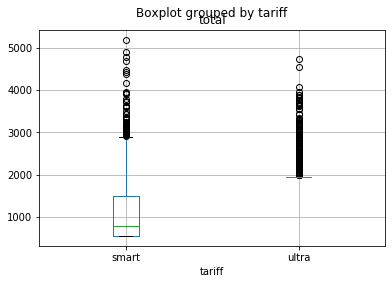

In [49]:
df.boxplot('total',by='tariff')

По данному виду графика непонятно какие границы по тарифу ultra. Попробуем построить гистограммы

Text(0.5, 1.0, 'total by smart')

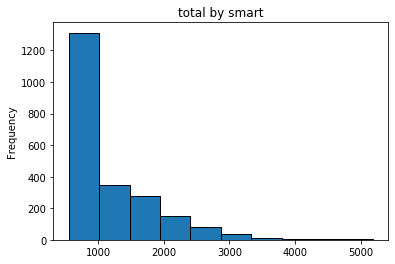

In [50]:
#посмотрим выручку
df[df['tariff'] == 'smart']['total'].plot(kind='hist', bins=10,ec='black')
plt.title('total by smart')

Text(0.5, 1.0, 'total by ultra')

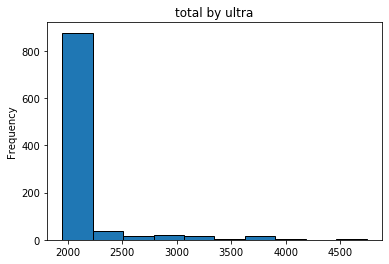

In [51]:
df[df['tariff'] == 'ultra']['total'].plot(kind='hist', bins=10,ec='black')
plt.title('total by ultra')

In [52]:
df.groupby('tariff')\
  .agg({'total':['median','mean','var','std']})

total                                        
       median         mean            var         std
tariff                                               
smart     796  1108.240915  500956.304142  707.782667
ultra    1950  2060.462944  126869.448067  356.187378

Выручка по тарифу ultra кажется больше, хотя больше пользователей с тарифом smart

Text(0.5, 1.0, 'messages_total_in_month by smart')

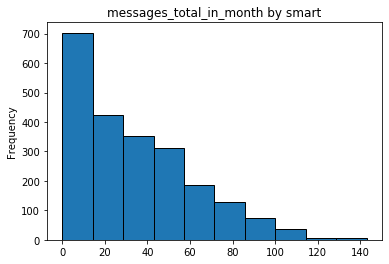

In [53]:
#Посмотрим сообщения
df[df['tariff'] == 'smart']['messages_total_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('messages_total_in_month by smart')

Text(0.5, 1.0, 'messages_total_in_month by ultra')

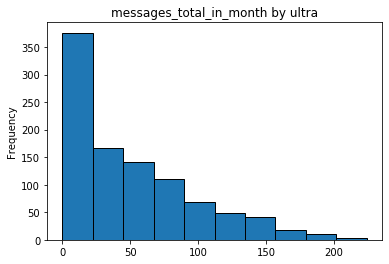

In [54]:
df[df['tariff'] == 'ultra']['messages_total_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('messages_total_in_month by ultra')

In [55]:
df.groupby('tariff')\
  .agg({'messages_total_in_month':['median','mean','var','std']})

messages_total_in_month                                   
                        median       mean          var        std
tariff                                                           
smart                     28.0  33.384029   796.812958  28.227876
ultra                     38.0  49.363452  2285.266143  47.804457

Почти одинаковое количество сообщений отправляют пользователи

Text(0.5, 1.0, 'calls total in month by smart')

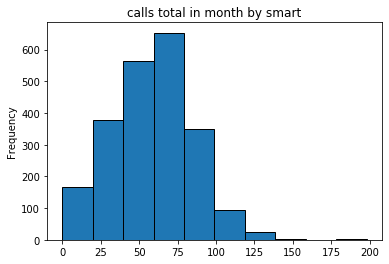

In [56]:
#Посмотрим звонки
df[df['tariff'] == 'smart']['calls_total_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('calls total in month by smart')

Text(0.5, 1.0, 'calls total in month by ultra')

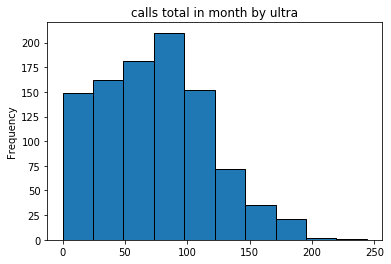

In [57]:
df[df['tariff'] == 'ultra']['calls_total_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('calls total in month by ultra')

In [58]:
df.groupby('tariff')\
  .agg({'calls_total_in_month':['median','mean','var','std']})

calls_total_in_month                                   
                     median       mean          var        std
tariff                                                        
smart                  60.0  58.463437   672.876243  25.939858
ultra                  74.0  73.392893  1928.689990  43.916853

По ultra происходит больше звонков (от 80 до 100), чем по тарифу smart

Text(0.5, 1.0, 'mb used in month by smart')

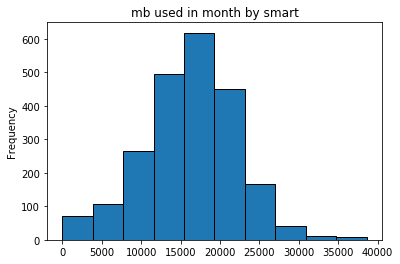

In [59]:
#Посмотрим пользование интернетом
df[df['tariff'] == 'smart']['mb_used_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('mb used in month by smart')

Text(0.5, 1.0, 'mb used in month by ultra')

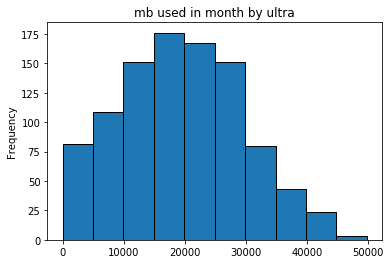

In [60]:
df[df['tariff'] == 'ultra']['mb_used_in_month'].plot(kind='hist', bins=10,ec='black')
plt.title('mb used in month by ultra')

In [61]:
df.groupby('tariff')\
  .agg({'mb_used_in_month':['median','mean','var','std']})

mb_used_in_month                                          
                 median          mean           var           std
tariff                                                           
smart           16531.0  16229.188425  3.454591e+07   5877.576978
ultra           19324.0  19486.901523  1.019356e+08  10096.317202

Также наблюдаем больше пользователей, пользующихся интернетом по тарифу ultra

### Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой. 
Гипотеза о равенстве средних двух генеральных совокупностей №1

Сформулируем гипотезы:
- Н0: Выручка тарифов  "Смарт" и "Ультра" не различается
- Н1: Выручка тарифов  "Смарт" и "Ультра" различается

In [62]:
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']

In [63]:
alpha = .05

In [64]:
ultra = ultra['total']
smart = smart['total']

In [81]:
print('Дисперсия тарифа ultra', np.var(ultra))
print('Дисперсия тарифа smart', np.var(smart))

Дисперсия тарифа ultra 126740.64659640804
Дисперсия тарифа smart 500731.5592770448


Т.к. показатели дисперсии сильно отличаются, для применения теста Тьюринга установим параметр equal_var = False 

In [65]:
results = st.ttest_ind(ultra, smart, equal_var = False)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


Гипотеза о равенстве средних двух генеральных совокупностей №2

Сформулируем гипотезы:

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [66]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [67]:
df['region'] = np.where(df['city'] == 'Москва', 'Москва', 'Провинция')

In [68]:
msc = df[df['region'] == 'Москва']
not_msc = df[df['region'] == 'Провинция']

In [69]:
msc = msc['total']
not_msc = not_msc['total']

In [82]:
print('Дисперсия пользователей из Москвы', np.var(msc))
print('Дисперсия пользвателей из провинций', np.var(not_msc))

Дисперсия пользователей из Москвы 544690.747233614
Дисперсия пользвателей из провинций 586549.7121188664


Аналогично применим equal_var = False

In [70]:
alpha = .05

In [84]:
results = st.ttest_ind(msc, not_msc,equal_var = False)
   
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.23445400148051448
Не получилось отвергнуть нулевую гипотезу


### Шаг 5. Напишите общий вывод

Сообщениями пользователи пользуются редко, не превышают лимит ни по тарифу ultra ни по ultra (примерно от 10 до 25)

Количество звонков превышает лимит по каждому тарифу. Можно порекомендовать оператору исправить округление нулевых минут до 1. Также по тарифу ultra огромный лимит звонков, пользователи столько не разговаривают, сколько они предлагают.


Можно отвергнуть гипотезы о том, что выручки тарифов не отличаются. Оно и объясняется, что разные условия дают разное количество пользователей и соответсвенно разную выручку. А вот гипотеза о том, что средняя выручка пользователей из Москвы не отличается от средней выручки из других городов может иметь силу (уровень p значимости 0.2312).

Чтобы увеличить выручку smart можно увеличить пакет интернет-трафика, т.к. интернетом пользователи пользуются чаще чем звонками и смс и некоторые пользуются сверх лимита


### Чек-лист готовности проекта

- [x] открыт файл
- [x] файлы изучены (выведены первые строки, метод info())
- [x] определены пропущенные значения
- [x] заполнены пропущенные значения
- [x] есть пояснение, какие пропущенные значения обнаружены
- [x] изменены типы данных
- [x] есть пояснение, в каких столбцах изменены типы и почему
- [x] для каждого пользователя посчитаны: количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; помесячная выручка с каждого пользователя  
- [x] описаны поведение клиентов оператора, исходя из выборки. Посчитаны среднее количество, дисперсия и стандартное отклонение. Построены гистограммы. Описаны распределения
- [x] проверены гипотезы
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод